> __**** Projet : Améliorez le produit IA de votre start-up ****__

__* Traitement d'image *__

L'entreprise souhaite améliorer sa plateforme avec une nouvelle fonctionnalité de collaboration. Les utilisateurs pourront par exemple poster des avis et des photos sur leur restaurant préféré. Ce sera aussi l’occasion, pour l’entreprise, de mieux comprendre les avis postés par les utilisateurs

Ce programme permet de :

- Détecter les sujets d’insatisfaction présents dans les commentaires postés sur la plateforme.
- Labelliser automatiquement les photos postées sur la plateforme. Par exemple, identifier les photos relatives à la nourriture, au décor dans le restaurant ou à l’extérieur du restaurant.

In [1]:
import pandas as pd
pd.options.plotting.backend = "plotly"

In [2]:
import timeit
import json
from functions import *
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import ImageOps 
from PIL import ImageFilter

In [3]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

In [4]:
# Récupération des données Yelp à travers l'API YELP

# Chargement des fichiers pour l'entrainement du modèle

In [5]:
PATH='./photos/'

In [6]:
photos = []
with open('./data/photos.json',encoding="utf8") as fl:
    for i, line in enumerate(fl):
        photos.append(json.loads(line))

df_photos = pd.DataFrame(photos)
df_photos.head()

df_photos[['photo_id','label']].to_csv('analyse_photos.csv',index=False)


# Echantillon de la base de données photos

Ces photos représentent un échantillon de la base de données des photos. Cette dernière contient 200 000 photos.
Toutes ces photos sont labellisées. Il y a 5 types de labels :
    - food
    - drink
    - inside
    - outside
    - menu

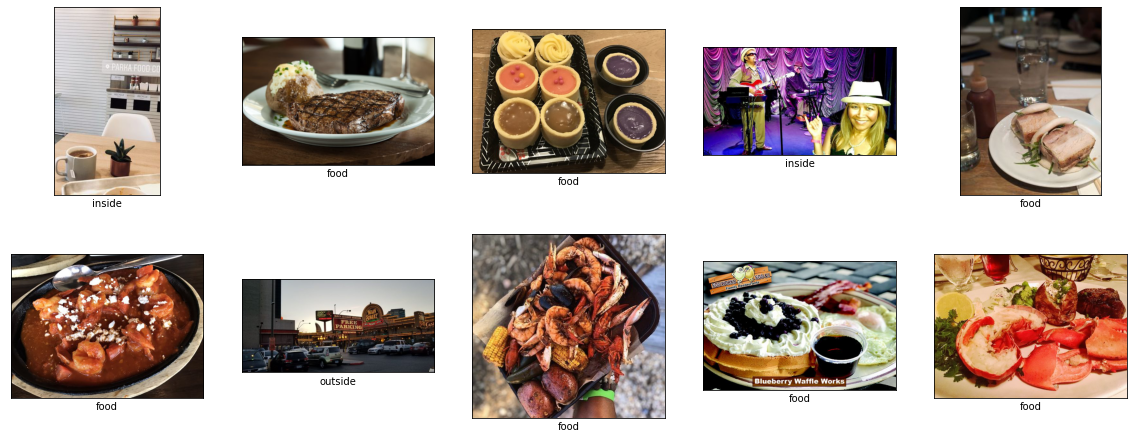

In [7]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image


import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    img_demo = Image.open("./photos/"+df_photos['photo_id'][i]+".jpg")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_demo, cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(df_photos['label'][i])

# Chargement du modèle VGG16

Nous allons charger un réseau de neurones préalablement formé, celui de VGG16, fourni avec Keras.

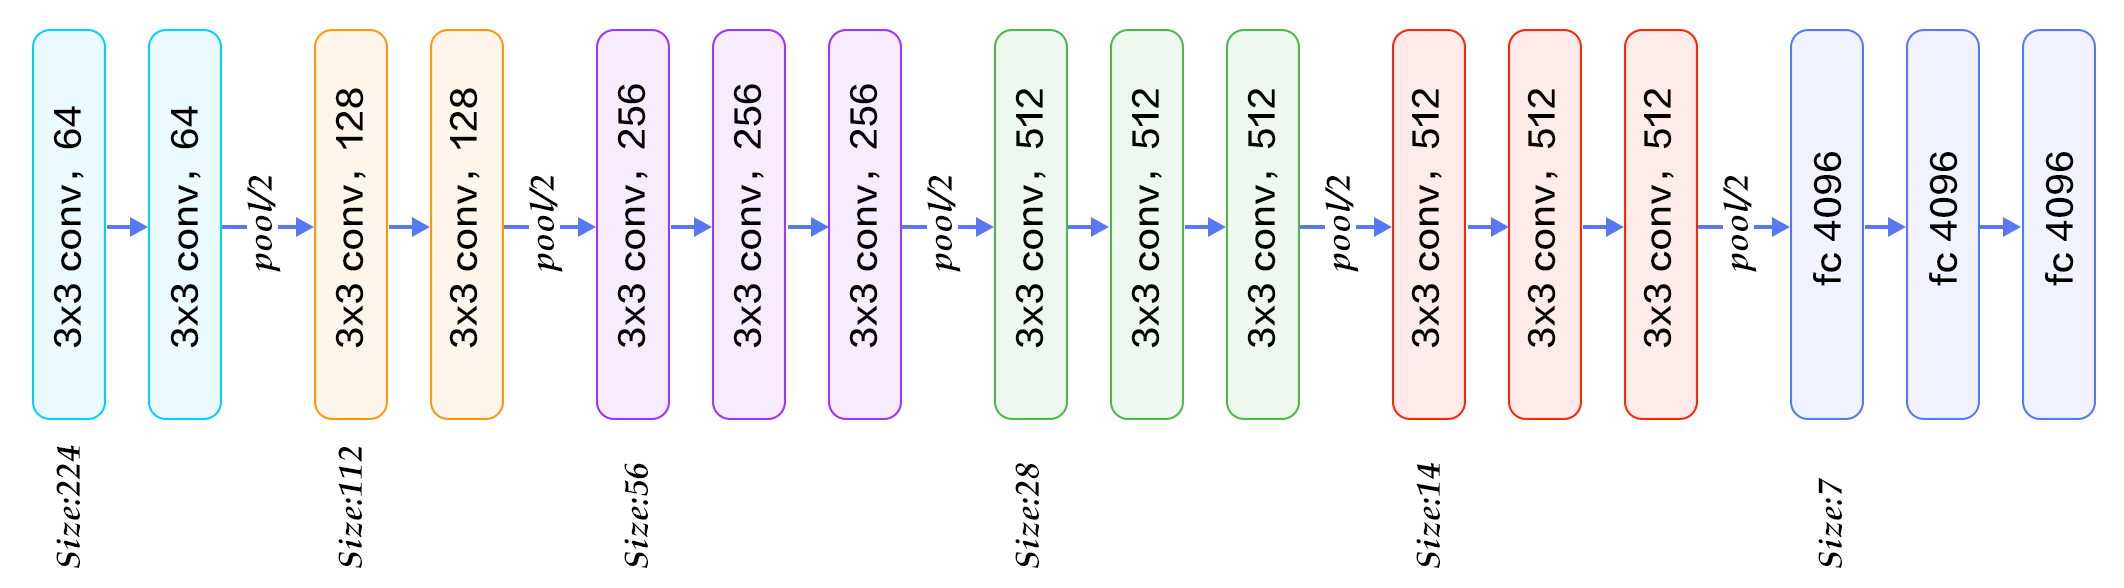


VGG-16 est constitué de plusieurs couches, dont 13 couches de convolution et 3 fully-connected. Il doit donc apprendre les poids de 16 couches.

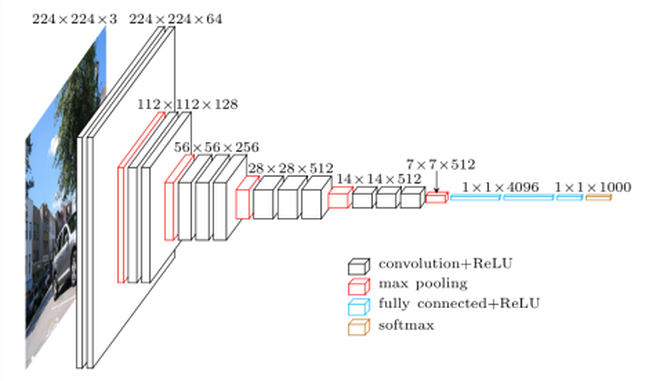

Nous allons copier le modèle, mais supprimer la dernière couche (la couche de classification), de sorte que la dernière couche du nouveau réseau, appelée feat_extractor soit la deuxième couche entièrement connectée à 4096 neurones, "fc2 (Dense)". Ceci va nous permettre d'extraire les features

In [8]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)


# Préparation des données et fichiers Train et Test

Afin de saisir une image dans le réseau, elle doit être prétraitée en un vecteur de caractéristiques de la taille correcte. Cette fonction load_image (path) gérera les étapes habituelles de prétraitement: charger une image de notre système de fichiers, l'égaliser et la transformer en un vecteur d'entrée aux dimensions attendues par VGG16, à savoir une image couleur de taille 224x224.

In [9]:
from keras.preprocessing import image
import requests
from io import BytesIO

def load_image(path):
    if path.startswith('http://') or path.startswith('https://') or path.startswith('ftp://'):
        response = requests.get(path)
        img = Image.open(BytesIO(response.content))
        img1 = img.resize(model.input_shape[1:3])
    else :
        if not os.path.exists(path):
            raise Exception('Input image file does not exist')
        img1 = image.load_img(path, target_size=(model.input_shape[1:3]))
        
    # applying equalize method  
    img = ImageOps.equalize(img1, mask = None)   
    # appliquer un filtre gaussien pour filtrer le bruit
#    img=img2.filter(ImageFilter.GaussianBlur(radius=2))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [10]:
def recuperer_image(a) :
    return PATH+a+'.jpg'

In [11]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
df_photos['label'] = labelencoder.fit_transform(df_photos['label'])

In [12]:
df_photos['photo_id'] = df_photos['photo_id'].apply(recuperer_image)

In [13]:
X = df_photos['photo_id'].values
y = df_photos['label'].values

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Extraction et affichage des features avec la méthode ORB

In [15]:
import cv2
import numpy as np

In [16]:
img = cv2.imread("./photos/---SnSf4OfUFfJmCxw1DZA.jpg")
orb = cv2.ORB_create(nfeatures=1500)
keypoints_orb, descriptors = orb.detectAndCompute(img, None)
img = cv2.drawKeypoints(img, keypoints_orb, None)

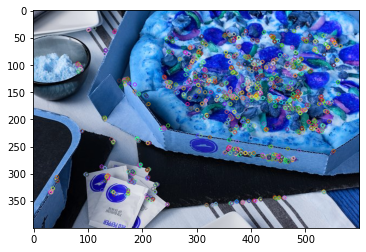

In [17]:
plt.imshow(img)

In [18]:
cv2.imshow("Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Extraction des Features avec la méthode du classifieur VGG16

Cette fonction  extraction_des_features permet d'extraire les features en se basant sur le classifieur VGG16. Ce classifieur forme une représentation très efficace de l'image afin de pouvoir la classer avec précision. 

In [19]:
def extraction_des_features(images) :
    tic = timeit.default_timer()
    features = []
    for i, image_path in enumerate(images):
        img, x = load_image(image_path);
        feat = feat_extractor.predict(x)[0]
        features.append(feat)
            
    print('finished extracting features for %d images' % len(images))
    features = np.array(features)
    print (' dimension of features before pca : ', features.shape )

    return features

In [20]:
X_train_features=extraction_des_features(X_train[:2000])

finished extracting features for 2000 images
 dimension of features before pca :  (2000, 4096)


In [21]:
X_test_features=extraction_des_features(X_test[:1000])

finished extracting features for 1000 images
 dimension of features before pca :  (1000, 4096)


# réduction de la dimension

Avant d'utiliser ces features, nous allons effectué une analyse en composantes principales (ACP) pour réduire la dimensionnalité de nos features à 265. Et ceci pour deux raisons:

1) les features de 4096 dimensions peuvent avoir une certaine redondance, de sorte que plusieurs éléments du vecteur sont fortement corrélés ou similaires. Cela fausserait les comparaisons de similarité vers ces caractéristiques sur-représentées.

2) L'exploitation de plus de 4096 éléments est inefficace à la fois en termes d'espace / mémoire requis et de vitesse du processeur, et il serait préférable pour nous de pouvoir réduire la longueur de ces vecteurs tout en conservant la même représentation effective. 

Ainsi, PCA réduit la quantité de redondance dans nos fonctionnalités (à partir de fonctionnalités dupliquées ou hautement corrélées), accélère le calcul sur celles-ci et réduit la quantité de mémoire qu'elles utilisent.

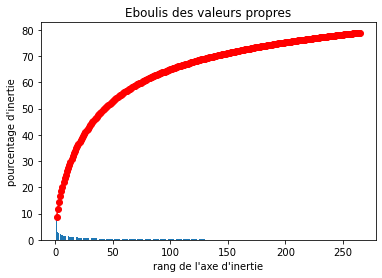

In [22]:
from functions import *
from sklearn.decomposition import PCA

pca = PCA(n_components=265)
pca.fit(X_train_features)
display_scree_plot(pca)

## ACP sur X_train_features et X_test_features

Réduction de la dimension de Train et test

In [23]:
X_train_features = pca.transform(X_train_features)

In [24]:
X_test_features = pca.transform(X_test_features)

# Modèle d'apprentissage non supervisé :  Kmeans

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn import metrics
from sklearn import cluster
from sklearn import preprocessing
from sklearn import cluster
from sklearn import preprocessing
import plotly.express as px
import datetime


In [26]:
# On commence par réduire l'echelle des données. On scale d’abord les données :
X_kmeans=X_train_features
mms = preprocessing.MinMaxScaler()
mms.fit(X_kmeans)
X_scaled = mms.transform(X_kmeans)

In [27]:
# Choice of clusters for kmeans
myclust = cluster.KMeans(n_clusters=5)
myclust.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## Visualisation avec T-SNE 

T-SNE est une technique de réduction de dimension pour la visualisation de données. Il s'agit d'une méthode non linéaire permettant de représenter un ensemble de points d'un espace à grande dimension dans un espace de deux ou trois dimensions, les données peuvent ensuite être visualisées avec un nuage de points.

In [28]:
# Applying TSNE to scaled data:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca')
X_trans = tsne.fit_transform(X_scaled)

In [41]:
# Display results
a = X_trans[:, 0]
b = X_trans[:, 1]
c = myclust.labels_
d= y_train[:2000]
e= X_train[:2000]
t = pd.DataFrame({'Component1':a,'Component2':b, 'Clusters':c, 'Labels': d, 'photos':e})
fig = t.plot.scatter(x="Component1", y="Component2", color='Clusters', title='clustering by clusters', hover_data=['Labels','photos'])
fig.show()

fig = t.plot.scatter(x="Component1", y="Component2", color='Labels', title='clustering by labels', hover_data=['Clusters','photos'])
fig.show()

PS : Nous constatons que les classifications par cluster et par label se ressemblent

# Apprentissage supervisé SVM

In [30]:
# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

In [31]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train_scaled, y_train[:2000])

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [33]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test_scaled)
Y_pred_label = list(labelencoder.inverse_transform(Y_pred))
Y_test_label= list(labelencoder.inverse_transform(y_test[:1000]))

Best score for training data: 0.9244999999999999 

Best C: 10 

Best Kernel: rbf 

Best Gamma: 0.001 



In [34]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(Y_test_label,Y_pred_label))

              precision    recall  f1-score   support

       drink       0.93      0.69      0.80        59
        food       0.96      0.99      0.97       605
      inside       0.89      0.93      0.91       266
        menu       1.00      0.50      0.67         6
     outside       0.89      0.78      0.83        64

    accuracy                           0.94      1000
   macro avg       0.94      0.78      0.84      1000
weighted avg       0.94      0.94      0.94      1000



# Prédire le label des images

Récupération des photos par l'API YELP sous forme d'un fichier csv

In [35]:
Yelp_photos=pd.read_csv('Yelp_photo.csv') 

In [36]:
def predire_une_image(im) :
    feat=extraction_des_features(im)
    X_features = pca.transform(feat)
    Y_features = final_model.predict(X_features)
    Y_features = list(labelencoder.inverse_transform(Y_features))
    return Y_features

Récupérer les prédictions des images d'entrée

In [37]:
pred_yelp = predire_une_image(Yelp_photos['photos'])

finished extracting features for 149 images
 dimension of features before pca :  (149, 4096)


## Affichage des images et leurs prédictions

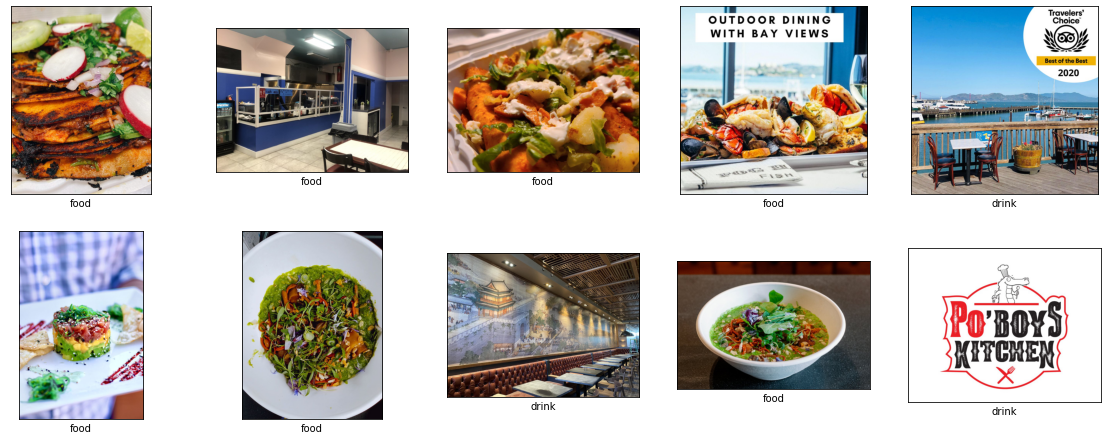

In [38]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image


import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    response = requests.get(Yelp_photos['photos'][i])
    img_demo = Image.open(BytesIO(response.content))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_demo, cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(pred_yelp[i])

In [39]:
import pickle

# pickle.dump([images, pca_features, pca], open('/content/features_5cats.p', 'wb'))
pickle.dump([pca_features, pca], open('features_yelp.p', 'wb'))

NameError: name 'pca_features' is not defined